# Import libraries

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import requests
import folium
from shapely.geometry import Polygon
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans

# Read info about districts of Chisinau City, Moldova

In [2]:
borders = gpd.read_file('Boundaries/chisinau.shp')
borders

,id,name,population,geometry
0,6,Durelsti,19400,"POLYGON ((226754.519 211545.036, 227267.766 21..."
1,5,Codru,16200,"POLYGON ((227861.950 203947.509, 227889.137 20..."
2,4,Ciocana,116800,"POLYGON ((236059.340 214010.164, 236950.837 21..."
3,7,Buiucani,109200,"POLYGON ((229073.639 213426.133, 229084.374 21..."
4,1,Riscani,145500,"POLYGON ((233223.177 209907.058, 232559.624 21..."
5,3,Botanica,172400,"POLYGON ((233386.658 204992.468, 233389.477 20..."
6,2,Centru,95200,"POLYGON ((228132.018 204671.323, 228233.020 20..."


# Get centroids of each district so we can find more places via foursquare API

In [3]:
borders_epsg4326 = borders.to_crs(epsg=4326)
center_x = list(borders_epsg4326.geometry.centroid.x)
center_y = list(borders_epsg4326.geometry.centroid.y)
print("District latitudes: ", center_x)
print("Disctrict longitudes: ", center_y)

E:\Anaconda\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


District latitudes:  [28.76005507655952, 28.82097956780799, 28.899220903799307, 28.791796525768053, 28.840161813314104, 28.89439141808501, 28.824507106369232]
Disctrict longitudes:  [47.02427940703145, 46.96640272742513, 47.0231106385667, 47.04069205771161, 47.04983953345079, 46.96720772993921, 47.004024867598396]


# Get the most east, west, north and south points for each district to cover more territory in order to find more venues (malls)

In [4]:
x = []
y = []

# Extract the point values that define the perimeter of the polygon
for value in borders_epsg4326.geometry:
    x_temp, y_temp  = value.exterior.coords.xy
    x.append(x_temp)
    y.append(y_temp)
    
south_x = [100] * borders.shape[0]
north_x = [0] * borders.shape[0]
west_x = [100] * borders.shape[0]
east_x = [0] * borders.shape[0]

south_y = [100] * borders.shape[0]
north_y = [0] * borders.shape[0]
west_y = [100] * borders.shape[0]
east_y = [0] * borders.shape[0]

for i in range(len(x)):
    for j in range(len(x[i])):
        # Westest point
        if x[i][j] < west_x[i]:
            west_x[i] = x[i][j]
            west_y[i] = y[i][j]
        # Eastest point
        if x[i][j] > east_x[i]:
            east_x[i] = x[i][j]
            east_y[i] = y[i][j]
        # Southest point
        if y[i][j] < south_y[i]:
            south_x[i] = x[i][j]
            south_y[i] = y[i][j]
        # Northest point
        if y[i][j] > north_y[i]:
            north_x[i] = x[i][j]
            north_y[i] = y[i][j]
            
main_points = list(zip(west_x + east_x + north_x + south_x + center_x, west_y + east_y + north_y + south_y + center_y))

# Specify parameters 

In [5]:
CLIENT_ID = 'yourID' # your Foursquare ID
CLIENT_SECRET = 'yourSecret' # your Foursquare Secret
VERSION = '20200101'
RADIUS = 2000
LIMIT = 100
OFFSET = 50
CATEGORY_ID = '4bf58dd8d48988d1fd941735' # Shopping Mall
CATEGORY_ID1 = '5744ccdfe4b0c0459246b4df' # Outlet Mall
print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: PDDQ4JJQUVK5PDDSZ5JFYOHE12PIS0QHUYPKBUMRWBA2S1ZW
CLIENT_SECRET:S5CSTRKKMAX5CA301CCDYNC5K5XH2ET03DNOUAVLKRWMK0UC


# Explore venues (shopping malls) around specified points
For each point make 2 calls with the offset, so we can have max. 150 venues per point.

In [6]:
results = []
OFFSET = 0
for idx, (longitude, latitude) in enumerate(main_points):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={:.2f},{:.2f}&radius={}&limit={}&offset={}&categoryId={},{}' \
    .format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, RADIUS, LIMIT, OFFSET, CATEGORY_ID, CATEGORY_ID1)
    
    results.append(requests.get(url).json())
    
OFFSET = 50
for idx, (longitude, latitude) in enumerate(main_points):
    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={:.2f},{:.2f}&radius={}&limit={}&offset={}&categoryId={}' \
    .format(CLIENT_ID, CLIENT_SECRET, VERSION, latitude, longitude, RADIUS, LIMIT, OFFSET, CATEGORY_ID, CATEGORY_ID1)
    
    results.append(requests.get(url).json())

# Concat the obtained results

In [7]:
overall_result = json_normalize(results[0]['response']['groups'][0]['items'])


for i in range(1, len(results)):
    res = json_normalize(results[i]['response']['groups'][0]['items'])
    res.rename(columns = {'venue.id' : 'id'}, inplace=True)
    overall_result = pd.concat([overall_result, res], sort=True)
    overall_result.drop_duplicates(subset='id', inplace=True)
overall_result.shape

(25, 21)

# Show obtained venues
Create choropleth district/population of Chisinau  
Show all mall locations on the map

In [8]:
city_lat = 47.0105
city_lng = 28.8638

m = folium.Map(location=[city_lat, city_lng], zoom_start=11)

gjson = borders.to_crs(epsg='4326').to_json()
# Add districts to map
folium.Choropleth(
    geo_data=gjson,
    name='choropleth',
    data=borders,
    columns=['name', 'population'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population'
).add_to(m)

for lat, lon, poi in zip(overall_result['venue.location.lat'], overall_result['venue.location.lng'], overall_result['venue.name']):
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='red',
        fill_opacity=0.7).add_to(m)

m

E:\Anaconda\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


# Add new column to the dataframe

In [9]:
categories = []
for i in range(overall_result.shape[0]):
    categories.append(overall_result['venue.categories'].iloc[i][0]['name'])
overall_result['Categories'] = categories

In [10]:
overall_result.Categories.value_counts()

Shopping Mall    24
Market            1
Name: Categories, dtype: int64

# Show changes in land use 2014-2019

In [11]:
gjson1 = gpd.read_file('MD001L1_CHISINAU_changes_2014_2019/MD001L1_CHISINAU_changes_2014_2019.shp')

In [12]:
points = folium.features.GeoJson(gjson1)

m = folium.Map(location=[city_lat, city_lng], zoom_start=11)

gjson = borders.to_crs(epsg='4326').to_json()
folium.Choropleth(
    geo_data=gjson,
    name='choropleth',
    data=borders,
    columns=['name', 'population'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population'
).add_to(m)
m.add_children(points)
m

E:\Anaconda\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
E:\Anaconda\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
E:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.


# Save all malls` locations to a list

In [13]:
from shapely.geometry import Point, Polygon
points = []
for i in range(overall_result.shape[0]):
    points.append(Point(np.array(overall_result['venue.location.lng'])[i], np.array(overall_result['venue.location.lat'])[i]))

# Count num of malls per distric

In [14]:
malls_count_per_district = [(sum([True if point.within(Polygon(poly)) else False for point in points])) for poly in borders.to_crs(epsg='4326').geometry]
malls_count_per_district

E:\Anaconda\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


[0, 0, 3, 5, 3, 7, 7]

In [15]:
borders['malls_count_per_district'] = malls_count_per_district

# Run KMeans algorithm to find clusters and relationships between malls_count_per_district and population

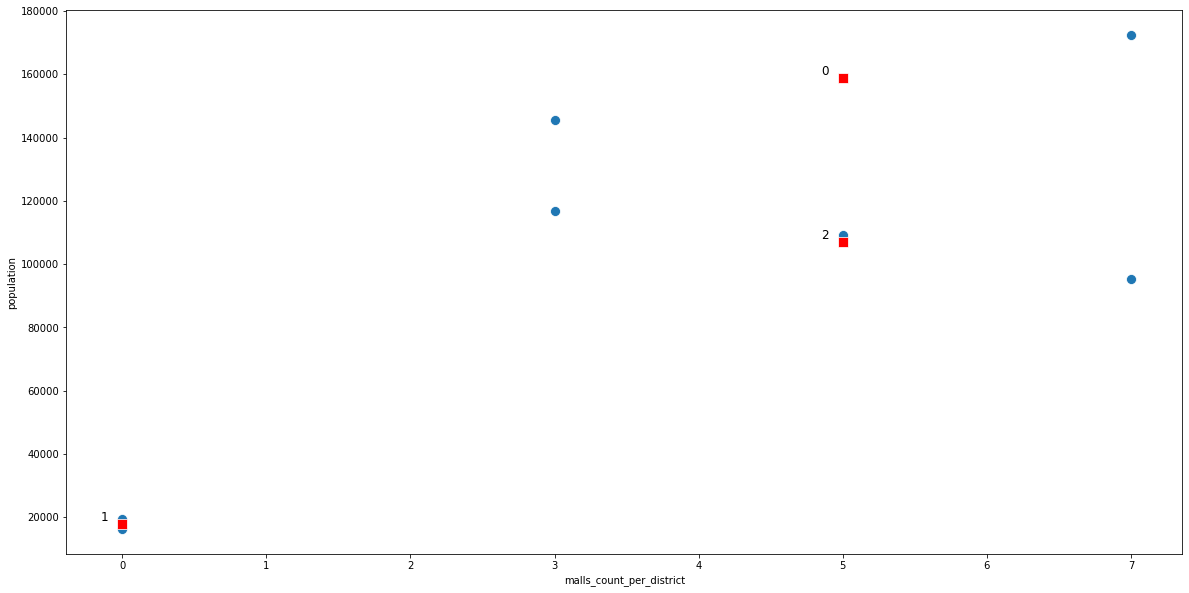

In [16]:
import seaborn as sns
from matplotlib import pyplot as plt
nclusters = 3
kmeans = KMeans(n_clusters = nclusters, random_state = 0).fit(borders[['population', 'malls_count_per_district']])

fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.scatterplot(ax=ax, x=borders['malls_count_per_district'], y=borders['population'], s=100)
sns.scatterplot(ax=ax, x=[v[1] for v in kmeans.cluster_centers_], y=[v[0] for v in kmeans.cluster_centers_], marker = 's', s=100, c=['red'])

# Add cluster index to plot
for idx, center in enumerate(kmeans.cluster_centers_):
    ax.text(center[1] - 0.15, center[0] + 1000, str(idx), fontsize=12)
    
plt.show()

In [17]:
borders['Cluster'] = kmeans.labels_
borders

,id,name,population,geometry,malls_count_per_district,Cluster
0,6,Durelsti,19400,"POLYGON ((226754.519 211545.036, 227267.766 21...",0,1
1,5,Codru,16200,"POLYGON ((227861.950 203947.509, 227889.137 20...",0,1
2,4,Ciocana,116800,"POLYGON ((236059.340 214010.164, 236950.837 21...",3,2
3,7,Buiucani,109200,"POLYGON ((229073.639 213426.133, 229084.374 21...",5,2
4,1,Riscani,145500,"POLYGON ((233223.177 209907.058, 232559.624 21...",3,0
5,3,Botanica,172400,"POLYGON ((233386.658 204992.468, 233389.477 20...",7,0
6,2,Centru,95200,"POLYGON ((228132.018 204671.323, 228233.020 20...",7,2


# Show colored version (according to clusters) of malls` locations

In [18]:
import folium

m = folium.Map(location=[47.0105, 28.8638], zoom_start=11)

borders_epsg4326 = borders.to_crs(epsg='4326')

gjson = borders_epsg4326.to_json()
# Add districts to map
folium.Choropleth(
    geo_data=gjson,
    name='choropleth',
    data=borders,
    columns=['name', 'population'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Population'
).add_to(m)

clusters_colors = ['red', 'black', 'blue']

for lat, lon, poi in zip(overall_result['venue.location.lat'], overall_result['venue.location.lng'], overall_result['venue.name']):
    if True in [Point(lon, lat).within(Polygon(poly)) for poly in borders_epsg4326.geometry]:
        color = borders.iloc[[Point(lon, lat).within(Polygon(poly)) for poly in borders_epsg4326.geometry].index(True)]['Cluster']
    label = folium.Popup(str(poi), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=clusters_colors[color],
        fill=True,
        fill_color=clusters_colors[color],
        fill_opacity=0.7).add_to(m)

m

E:\Anaconda\lib\site-packages\pyproj\crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
